## Importer les librairies

In [1]:
#! pip install numpy 
#! pip install pandas 
#! pip install matplotlib 
#! pip install plotly 
#! pip install nltk 
#! pip install textblob 
#! pip install wordcloud 
#! pip install scikit-learn
#! pip install sklearn 
#! pip install openpyxl
#! pip install nbformat==4.2.0
#! python -m textblob.download_corpora


In [2]:
# Basic Libraries 📚
# --------------------------------------
import numpy as np
import pandas as pd
import re

# Plot library 📊
# --------------------------------------
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio


# NLP
# --------------------------------------
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud  # visualization of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


# Metrics 📐
# --------------------------------------
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder


# Machine Learning Models 🤖
# --------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Customize to Remove Warnings and Better Observation 🔧
# --------------------------------------------------------
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Problèmatique

Augmenter ses ventes en analysant les commentaires reçus sur des produits, et améliorer leurs caractéristiques en fonction des plaintes reçues. Conformément à cet objectif, les commentaires seront étiquetés en effectuant une analyse des sentiments et un modèle de classification sera créé avec les données étiquetées.

### Les données

L'ensemble de données comprend les commentaires faits pour un certain groupe de produits, le titre du commentaire, le nombre d'étoiles et les variables qui indiquent combien de personnes ont trouvé le commentaire utile.

### Import du dataset :

In [3]:
df = pd.read_excel("amazon.xlsx")
df.head(15)

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...
5,5,0,Not for us,Looks different then photo
6,5,0,Perfect for spa room,Was exactly what i was looking for. Heavy mate...
7,5,0,Actually better than expected,"Looking at the picture, I thought these curtai..."
8,4,0,Not what expected,Much whiter than I thought it would be and was...
9,5,0,Pretty as a Picture,These are curtains just as the picture shows. ...


#### Suppression des nulls

In [4]:
print("Il y a",df['Review'].isnull().sum(),"avis sans commentaire(s)")

Il y a 18 avis sans commentaire(s)


In [5]:
df.dropna(subset=['Review'], inplace=True)
df.isnull().sum()

Star        0
HelpFul     0
Title      43
Review      0
dtype: int64

## Pré Traitement du texte

### Minuscule

In [6]:
# to put all the characters in a standard
print(df['Review'].head())
df['Review'] = df['Review'].str.lower()  # make all lowercase
df['Review'].head()

0                                        Happy with it
1    Good quality material however the panels are m...
2    Product was fun for bedroom windows.<br />Imag...
3     Lo unico que me gustaria es que sean un poco ...
4    Great bang for the buck I can't believe the qu...
Name: Review, dtype: object


0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object

### Ponctuation

Tout comme les majuscules et les minuscules, les signes de ponctuation ne contiennent pas de valeur de mesure. Par exemple, si nous pensons que nous faisons un exemple de classification, il y a 2 avis, l'un d'eux a beaucoup plus de points/virgules. Dans cette situation, nous n'attendons AUCUN modèle des ponctuations. Bien qu'il s'agisse de l'approche courante, elle peut varier en fonction du problème.


In [7]:
# check sentences and replace punctions with spaces
print(df['Review'].head())

df['Review'] = df['Review'].str.replace('[^\w\s]', '')
print(df['Review'].head())


0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object
0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object


### Chiffres

RAPPEL :
Comme ci-dessus, notre problématique peut avoir une discrimination sur les nombres. Par exemple, inclure beaucoup ou moins de nombres peut être crucial pour le problème. Dans ce type de problème, la suppression des nombres n'est pas une méthode à utiliser. Dans notre exemple, nous supprimons les nombres car ils ne sont pas significatifs.

L'approche générale consiste à supprimer toutes les structures problématiques en dehors du texte. Par exemple, lorsqu'il y a des données de médias sociaux, nous pouvons choisir de supprimer les émojis, les liens de pages, etc.

Ici, Nous détectons les chiffres via une expression régulière. \d nous aide à capturer les chiffres.


In [8]:
print(df['Review'].head())

df['Review'] = df['Review'].str.replace('\d', '')  

print(df['Review'].head())


0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object
0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object


### Balises HTML

In [9]:
CLEANR = re.compile('<.*?>') 

print(df['Review'].head())

df['Review'] = df['Review'].apply(lambda x: re.sub(CLEANR, ' ', x))

print(df['Review'].head())

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object
0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows. imagery a...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object


### Caractère spéciaux

In [10]:
clean = re.compile(r'[^a-zA-Z0-9]')
df['Review'] = df['Review'].apply(lambda x: re.sub(clean, ' ', x))

### Stopword

Les mots couramment utilisés dans la langue n'ont pas de mesure. Des expressions telles que diverses conjonctions telles que est, pour, ceci ou divers pronoms n'ont pas de signification métrique. Par conséquent, nous supprimerons ces expressions.

Nous devons télécharger « stopwords » de la bibliothèque nltk. Il a été préparé pour l'anglais, il existe également des études pour d'autres langues. Par conséquent, vous pouvez utiliser la langue que vous souhaitez comme argument.

In [11]:
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [12]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['Review'].head(5)

0                                                happy
1     good quality material however panels mis matched
2    product fun bedroom windows imagery bit stretc...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

### Lemmatization


In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')

df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(5)


[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


0                                                happy
1       good quality material however panel mi matched
2    product fun bedroom window imagery bit stretch...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object

## Visualisation


### Fréquence

In [14]:
# extract the term frequencies(frequency of the words) and create a df
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head(10)

,index,0
0,happy,203.00
1,good,542.00
2,quality,905.00
3,material,584.00
4,however,83.00
5,panel,232.00
6,mi,10.00
7,matched,14.00
8,fun,70.00
9,product,269.00


In [15]:
# fix the column names
tf.columns = ["words", "tf"]  

In [16]:
# to see the most frequent words
tf.sort_values("tf", ascending=False)

,words,tf
52,curtain,2630.00
41,look,1548.00
117,love,1475.00
88,room,1155.00
164,like,1066.00
...,...,...
5354,maintenance,1.00
5353,static,1.00
5352,collect,1.00
5351,merchandise,1.00


### Bar Plot

Nous avons des milliers de mots. Comme il ne serait pas logique de les afficher tous, prenons ceux dont la fréquence est acceptable.

Le nombre 300 a été choisi ici, mais il est optionnel et peut être modifié.



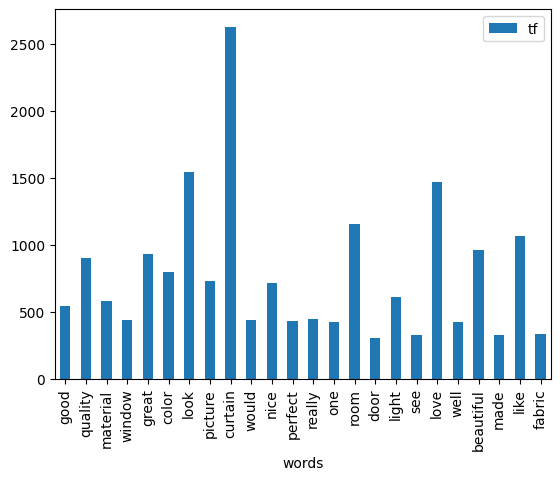

In [17]:
tf[tf["tf"] > 300].plot.bar(x="words", y="tf")
plt.show()

### WordCloud

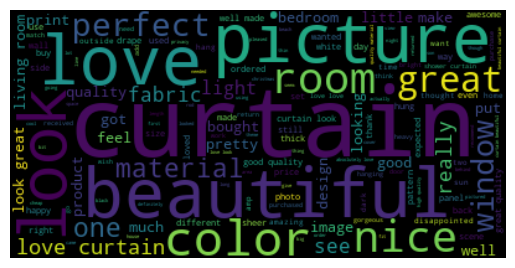

In [18]:
text = " ".join(i for i in df.Review) 

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

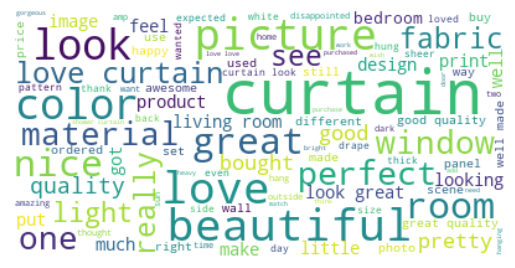

In [19]:
# configure the graph
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Analyse de sentiments

Cette section sera divisée en 2 parties. La première partie explique les méthodes et comment utiliser l'analyse des sentiments. La deuxième partie concerne la mise en œuvre de l'analyse des sentiments dans notre ensemble de données.

L'analyse des sentiments vise à exprimer l'état émotionnel des textes de manière mathématique. Supposons que nous ayons une phrase, chaque mot qui la compose a une signification positive/négative/neutre. Ces significations sont évaluées de manière holistique et des évaluations sont faites pour déterminer si un texte est positif ou négatif.


In [20]:
nltk.download('vader_lexicon')  # pre-trained model for sentiment analysis

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [21]:
# Example 1
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [22]:
# Example 2
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [23]:
df['Review']

0                                                   happy
1          good quality material however panel mi matched
2       product fun bedroom window imagery bit stretch...
3       lo unico que gustaria e que sean un poco ma la...
4       great bang buck believe quality material vibra...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme studio li...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5593, dtype: object

In [24]:
df['compound'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['neg'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['neg'])
df['neu'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['neu'])
df['pos'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['pos'])

df

,Star,HelpFul,Title,Review,compound,neg,neu,pos
0,5,0,looks great,happy,0.57,0.00,0.00,1.00
1,5,0,Pattern did not align between the two panels.,good quality material however panel mi matched,0.44,0.00,0.67,0.33
2,5,0,Imagery is stretched. Still fun.,product fun bedroom window imagery bit stretch...,0.85,0.00,0.52,0.48
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.00,0.00,1.00,0.00
4,5,0,Wow great purchase,great bang buck believe quality material vibra...,0.90,0.00,0.49,0.51
...,...,...,...,...,...,...,...,...
5606,4,0,Recommend,great product reasonable money delivered quick...,0.77,0.00,0.60,0.40
5607,5,0,"Terrible , different colors. I returned",color way panel match,0.00,0.00,1.00,0.00
5608,5,0,Extremely pleasing,great studio complement entire theme studio li...,0.79,0.00,0.63,0.37
5609,5,0,Perfect,brought beauty kid room love,0.84,0.00,0.27,0.73


In [25]:
df['Polarity Scores'] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Polarity Scores"].value_counts()

Polarity Scores
pos    4833
neg     760
Name: count, dtype: int64

In [26]:
df.groupby("Polarity Scores")["Star"].mean()

Polarity Scores
neg   3.37
pos   4.57
Name: Star, dtype: float64

In [27]:
df["Polarity Scores"] = LabelEncoder().fit_transform(df["Polarity Scores"])

In [28]:
y = df["Polarity Scores"]
X = df["Review"]

In [29]:
print(" X ".center(50, "~"))
display(X.head())
print("")
print(" Y ".center(50, "~"))
display(y.head())

~~~~~~~~~~~~~~~~~~~~~~~ X ~~~~~~~~~~~~~~~~~~~~~~~~


0                                                happy
1       good quality material however panel mi matched
2    product fun bedroom window imagery bit stretch...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck believe quality material vibra...
Name: Review, dtype: object


~~~~~~~~~~~~~~~~~~~~~~~ Y ~~~~~~~~~~~~~~~~~~~~~~~~


0    1
1    1
2    1
3    0
4    1
Name: Polarity Scores, dtype: int64

En d'autres termes, nous devons effectuer de telles opérations sur X afin de pouvoir le mettre dans un format mesurable, sur lequel des opérations mathématiques et une modélisation par apprentissage automatique peuvent être effectuées. Pour cela, nous devons créer des vecteurs de mots. Méthodes couramment utilisées :

- Count Vectors
- TF-IDF
- Autres méthodes d'incorporation de mots (Word2Vec, GloVe, BERT, etc.)

Nous analyserons l'implémentation de Count Vectors et TF-IDF. D'autres méthodes d'incorporation de mots peuvent être recherchées et appliquées avec un prétraitement similaire (comme la suppression des ponctuations, des nombres, etc.). Chacune de ces méthodes est la méthode utilisée par l'ordinateur pour mettre ces textes dans des opérations mathématiques dans le monde de l'algèbre linéaire. Le texte que j'ai est sous la forme d'un texte et je dois faire quelque chose avec ce texte pour qu'il puisse être traité dans le monde de l'algèbre linéaire. Commençons par l'explication des méthodes et l'application sur notre ensemble de données.

## Count Vector 

In [30]:
a = """ngram is a contiguous sequence of n items from a given sample of text or speech."""

TextBlob(a).ngrams(3)  # For example, let's create a triple ngram

[WordList(['ngram', 'is', 'a']),
 WordList(['is', 'a', 'contiguous']),
 WordList(['a', 'contiguous', 'sequence']),
 WordList(['contiguous', 'sequence', 'of']),
 WordList(['sequence', 'of', 'n']),
 WordList(['of', 'n', 'items']),
 WordList(['n', 'items', 'from']),
 WordList(['items', 'from', 'a']),
 WordList(['from', 'a', 'given']),
 WordList(['a', 'given', 'sample']),
 WordList(['given', 'sample', 'of']),
 WordList(['sample', 'of', 'text']),
 WordList(['of', 'text', 'or']),
 WordList(['text', 'or', 'speech'])]

In [31]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']
# word frequency
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_c = vectorizer.fit_transform(corpus)  # we transformed the corpus with fit_transform
vectorizer.get_feature_names_out()  

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [32]:
X_c.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [33]:
vectorizer = CountVectorizer()  # default => word count
X_count = vectorizer.fit_transform(X)  # X stands for texts, we only count the frequencies of the words
vectorizer.get_feature_names_out()

array(['00', '000', '01', ..., 'zoom', 'zoomed', 'zooming'], dtype=object)

In [34]:
X_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
# word frequency
tf_idf_word_vectorizer = TfidfVectorizer()  # default = word frequency
corpus_tf_idf_word = tf_idf_word_vectorizer.fit_transform(corpus)
tf_idf_word_vectorizer.get_feature_names_out()
corpus_tf_idf_word.toarray()


array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

In [36]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
corpus_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)
tf_idf_ngram_vectorizer.get_feature_names_out()

array(['00 65', '00 65 00', '00 maybe', ..., 'zoomed set curtain',
       'zooming closely', 'zooming closely detail'], dtype=object)

In [37]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [38]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

In [39]:
# Words with TF-IDF
log_model = LogisticRegression().fit(X_tf_idf_word, y)
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.8995178419269696)

In [40]:
new_review = pd.Series("this product is great")

# vectorize the new review
new_review = TfidfVectorizer().fit(X).transform(new_review)

# predict the sentiment of review
log_model.predict(new_review)

array([1])

In [41]:
# Let's pick a sample comment from the original dataset and ask it to the model
sample = df["Review"].sample(1).values
print(sample)
random_review = pd.Series(sample)
new_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

['beautiful vibrant give space pleasant natural feeling since real']


array([1])

In [42]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
print("Count Vectors Score", cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()) 

# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
print("TF-IDF Word-Level Score", cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean())

# TF-IDF N-Gram
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
print("TF-IDF N-Gram Score", cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean())

Count Vectors Score 0.9318790256442229
TF-IDF Word-Level Score 0.9236538821238615
TF-IDF N-Gram Score 0.8685855470879474


In [43]:
%%time
def score(method_list):
    scores = []
    for method in method_list:
        rf_model = RandomForestClassifier().fit(method, y)
        scores.append(cross_val_score(rf_model, method, y, cv=5, n_jobs=-1).mean())
        
    scores_df = pd.DataFrame({"Methods": ["Count Vectors", "TF-IDF Word-Level", "TF-IDF N-Gram"],
                             "Scores": scores})
    
    trace1 = go.Bar(
                    y = scores_df["Methods"],
                    x = scores_df["Scores"],
                    name = "Accuracy Plot",
                    text=[round(i,5) for i in scores_df['Scores']],
                    marker = dict(color = ['#2ECC71','#34495E','#D0D3D4'],
                                 line=dict(color='rgb(0,0,0)',width=1.5)),
        orientation='h', textposition = 'inside'
    )
    data = [trace1]
    layout = go.Layout(barmode = "group", 
                       title={'text': "Scores" ,
                                 'y':0.9,
                                 'x':0.5,
                                 'xanchor': 'center',
                                 'yanchor': 'top'},
                          template='plotly_white')
    fig = go.Figure(data = data, layout = layout)
    pio.show(fig)
    
method_list = [X_count, X_tf_idf_word, X_tf_idf_ngram]
score(method_list)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed